In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sys
sys.path.append('../scripts/')
import pecube_tools as pt
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

In [3]:
from scipy import stats

In [4]:
def get_mappable(cmin, cmax, cmap=cm.jet):
    clim = ([cmin, cmax]) # color limits
    cnorm = colors.Normalize(clim[0], clim[1])
    col_map = cm.ScalarMappable(norm=cnorm, cmap=cmap)
    col_map._A=[]
    
    return col_map
    
def get_color(val, cmin, cmax, cmap=cm.jet):

    col_map = get_mappable(cmin, cmax, cmap)

    return col_map.to_rgba(val)




*Read in thermo data (observations)*

In [5]:
thermo_df = pd.read_csv('../data/thermo/ssrthermodata_sample names.txt',
                        delim_whitespace=True, names=np.arange(53))

thermo_df = thermo_df.loc[:, 0:10]

thermo_df.columns = ['lon', 'lat', 'elev', 'aHe_age', 'aHe_err', 
                     'aFt_age', 'aFt_err', 'zHe_age', 'zHe_err', 'zFt_age', 'zFt_err']

thermo_df.replace(-9999.0, np.nan, inplace=True)

print(thermo_df.shape)

thermo_df.head()

(31, 11)


,lon,lat,elev,aHe_age,aHe_err,aFt_age,aFt_err,zHe_age,zHe_err,zFt_age,zFt_err
12WC01,-114.3292,38.9474,2710,NaN,NaN,NaN,NaN,36.966834,5.408945,NaN,NaN
12WC02,-114.3366,38.9484,2567,NaN,NaN,NaN,NaN,41.475371,2.350846,NaN,NaN
12WC03,-114.3449,38.9512,2472,NaN,NaN,NaN,NaN,40.687395,4.857928,NaN,NaN
12SC01,-114.2983,38.9444,3316,NaN,NaN,NaN,NaN,41.737157,2.606043,NaN,NaN
12SC03,-114.2886,38.9425,3224,15.076327,2.368686,NaN,NaN,40.214654,0.655591,NaN,NaN


In [6]:
# get column with distance to detachment from other file

cols = list(range(53))
cols.insert(0, 'detach_dist')

dist_df = pd.read_csv('../data/ssrthermodata_with distances.txt', delim_whitespace=True,
                      skiprows=1, names = cols)

thermo_df['detach_dist'] = dist_df['detach_dist'].values

dist_df.detach_dist.head()

0    12.28
1    12.96
2    13.73
3     9.68
4     8.82
Name: detach_dist, dtype: float64

*Read in run parameters*

In [7]:
run_params = pd.read_csv('../scripts/run_params_heat_mods.csv', index_col=0)

run_params.head()

,tA1,tA2,tA3,tA4,tA5,rA1,rA2,rA3,rA4,ssrd_extension,...,tB3,tB4,rB1,rB2,rB3,wpf_extension,net_extension,run_id,moho_T,heat_prod
0,69.997573,63.412860,58.207171,48.413903,0,1.900446,2.113552,0.763651,0,30.074345,...,9.034202,0,0.036764,2.603172,0.141319,1.757208,31.831553,debbd7,986.318721,29.514008
1,69.939995,69.140288,31.809204,28.087621,0,5.806374,0.684549,0.848311,0,32.364606,...,5.779834,0,0.139008,0.103851,0.466826,2.621356,34.985962,6f4706,696.076930,20.775593
2,68.351801,65.782942,59.478905,41.328390,0,7.280874,0.141207,0.089319,0,20.584731,...,18.637099,0,0.738134,1.074443,0.120012,3.338910,23.923641,4615ed,857.645699,45.484821
3,19.821515,19.747063,5.564714,5.270460,0,1.862478,1.706600,0.694325,0,23.817425,...,0.467390,0,0.490473,0.067491,3.008740,3.806121,27.623547,a2536b,714.300307,13.916095
4,28.745806,28.112306,25.595852,23.025243,0,7.400546,3.500297,7.768461,0,32.472164,...,0.039475,0,0.645773,0.037049,0.932533,2.361638,34.833802,e964c2,883.286506,41.246766


In [8]:
run_params = run_params.set_index('run_id')

*Read in comparison files (model results)*

In [9]:
compar_dir = os.path.abspath('../comparisons/')

compar_list = os.listdir(compar_dir)

len(compar_list)

9981

In [10]:
run_list = []

for compar in compar_list:
    run = compar.split(sep='.')[1]
    run_list.append(run)

In [12]:
run_series = pd.Series(run_list)

run_series.to_csv('run_list.csv', index=False)

del run_series

In [11]:
sample_list = open('../data/thermo/ordered_sample_list.txt', 'r').read().split('\n')

if sample_list[-1] == '':
    sample_list = sample_list[:-1]

len(sample_list)

31

In [12]:
calc_cols = ['aHe_calc', 'aFt_calc', 'zHe_calc', 'zFt_calc']
obs_cols = ['aHe_obs', 'aFt_obs', 'zHe_obs', 'zFt_obs']

In [27]:
def load_comp_file(compar):
    
    runfile = compar_dir + '/' + compar
    run_id = compar.split('.')[1]
    
    df = pt.read_comparison(runfile, put_nans='yes')
    
    df.index=sample_list
    
    df = df[calc_cols]
    df['run_id'] = run_id
    df['sample'] = df.index
    
    df = df.set_index(['run_id', 'sample'])
    
    return df

In [28]:
#master_df = pd.concat([load_comp_file(cf) for cf in compar_list])

In [13]:
#master_df.to_csv('master_df.csv')


master_df = pd.read_csv('master_df.csv', index_col=[0,1])

In [14]:
master_df.head()

aHe_calc  aFt_calc  zHe_calc  zFt_calc
run_id sample                                        
dd5db3 12WC01   24.9097   27.9072   29.7610   51.8229
       12WC02   24.4846   26.5690   28.7016   47.6108
       12WC03   24.5544   26.3846   27.5302   41.7992
       12SC01   28.0091   30.4206   32.1660   55.8079
       12SC03   28.0830   30.9349   31.7389   55.9187

*now make misfit function*

In [15]:
age_df = thermo_df.loc[:,['aHe_age', 'zHe_age', 'aFt_age', 'zFt_age']]
age_df.columns = ['aHe_calc', 'zHe_calc', 'aFt_calc', 'zFt_calc']
err_df = thermo_df.loc[:,['aHe_err', 'zHe_err', 'aFt_err', 'zFt_err']]
err_df.columns = ['aHe_calc', 'zHe_calc', 'aFt_calc', 'zFt_calc']

In [16]:
#These samples are not in the Pecube footwall

age_df.loc[['UP-20', 'UP-18', 'FT-44']] = np.nan

age_df.loc[['UP-20', 'UP-18', 'FT-44']]

,aHe_calc,zHe_calc,aFt_calc,zFt_calc
UP-20,NaN,NaN,NaN,NaN
UP-18,NaN,NaN,NaN,NaN
FT-44,NaN,NaN,NaN,NaN


In [17]:
age_df.count().sum()

34

In [18]:
fit_df = pd.DataFrame(index=run_list, columns=['chi_sq_dof'])

In [19]:
def l2_misfit(model_df, obs_df, err_df):
    
    diff = model_df - obs_df
    
    misfit = (diff**2 / (2 * err_df**2) )
    
    return misfit


def chi_sq_dof(model_df, obs_df, err_df):
    
    n_obs = obs_df.count().sum()
    
    misfit = l2_misfit(model_df, obs_df, err_df)
    
    
    return misfit.sum().sum() / n_obs      

In [22]:
%%time

chisq = np.zeros(len(run_list))

for i, run in enumerate(run_list):
    
    chisq[i] = chi_sq_dof(master_df.loc[run], age_df, err_df)
    
fit_df['chi_sq_dof'] = chisq

CPU times: user 2min 11s, sys: 235 ms, total: 2min 11s
Wall time: 2min 11s


In [25]:
fit_df['chi_sq_rel_like'] = np.exp( - (fit_df.chi_sq_dof - fit_df.chi_sq_dof.min()) )

In [26]:
fit_df.sort('chi_sq_rel_like', ascending=False).chi_sq_rel_like.head(16)

2722de    1.000000
2824c7    0.594937
e4230e    0.591369
e953f6    0.583895
aee6b5    0.566514
91f5e2    0.556534
3e2b35    0.551356
f1427f    0.507096
9d629b    0.489395
14468e    0.484391
eb2234    0.475533
f1df55    0.463870
307b40    0.457305
f16972    0.451582
5e68b4    0.434604
538629    0.434206
Name: chi_sq_rel_like, dtype: float64

In [27]:
fit_df.sort(columns='chi_sq_dof', ascending=True).head()

,chi_sq_dof,chi_sq_rel_like
2722de,1.728681,1.000000
2824c7,2.247981,0.594937
e4230e,2.253995,0.591369
e953f6,2.266715,0.583895
aee6b5,2.296935,0.566514


In [63]:
fit_df.to_csv('fit_df.csv')

In [28]:
np.random.seed(69)
rands = np.random.uniform(size=len(run_list))

chi_sq_keeps = fit_df[fit_df.chi_sq_rel_like >= rands]

print('chi_sq', len(chi_sq_keeps.index))


chi_sq 39


In [64]:
chi_sq_keeps.to_csv('chi_sq_keeps.csv')

In [29]:
ssrd_dip_deg = 14
ssrd_dip_rad = np.radians(ssrd_dip_deg)
wpf_dip_deg = 51
wpf_dip_rad = np.radians(wpf_dip_deg)

In [30]:
time_vec = pt.make_time_vector(80, time_step_Ma = 0.01)

In [36]:
def wpf_rate_history(run_id, run_params_df):
    
    
    fpd = run_params_df.loc[run_id]
    
    wpf_rate_history = pt.calc_horiz_strain_history(fpd, fault='B',
                            fault_dip = wpf_dip_rad, start_time=80,
                            timesteps=[1,2,3], 
                            time_step_Ma=0.01)
    
    return wpf_rate_history


def ssrd_rate_history(run_id, run_params_df):
    
    fpd = run_params_df.loc[run_id]
    ssrd_rate_history = pt.calc_horiz_strain_history(fpd, fault='A',
                            fault_dip = ssrd_dip_rad, start_time=80,
                            timesteps=[1,2,3,4], 
                            time_step_Ma=0.01)
    
    return ssrd_rate_history


def ssr_ext_history(run_id, run_params_df):

    ssrd_history = ssrd_rate_history(run_id, run_params_df)
    wpf_history = wpf_rate_history(run_id, run_params_df)
    
    return ssrd_history + wpf_history


In [41]:
rate_history_wpf = pd.DataFrame(np.array([wpf_rate_history(run, run_params) for run in run_list]),
                                index=run_list, columns=time_vec)

rate_history_ssrd = pd.DataFrame(np.array([ssrd_rate_history(run, run_params) for run in run_list]),
                                 index=run_list, columns=time_vec)

ext_history_ssr = rate_history_ssrd + rate_history_wpf

In [42]:
rate_history_wpf.to_csv('ext_rate_history_wpf.csv')
rate_history_ssrd.to_csv('ext_rate_history_ssrd.csv')
ext_history_ssr.to_csv('ext_rate_history_ssr.csv')

In [39]:
rate_history_wpf.shape

(9981, 8001)

In [47]:
wpf_chi_sq_rate_history = pd.DataFrame(index=time_vec,
                                   columns=chi_sq_keeps.index.values)

chi_sq_rate_history = pd.DataFrame(index=time_vec,
                                   columns=chi_sq_keeps.index.values)

chi_sq_rate_history = chi_sq_rate_history.astype('float')
wpf_chi_sq_rate_history = wpf_chi_sq_rate_history.astype('float')

In [48]:
for run_id in chi_sq_keeps.index.values:
    chi_sq_rate_history.loc[:,run_id] = ssr_ext_history(run_id,
                                                    run_params)


In [49]:
for run_id in chi_sq_keeps.index.values:

    wpf_chi_sq_rate_history.loc[:,run_id] = wpf_rate_history(run_id,
                                                    run_params)

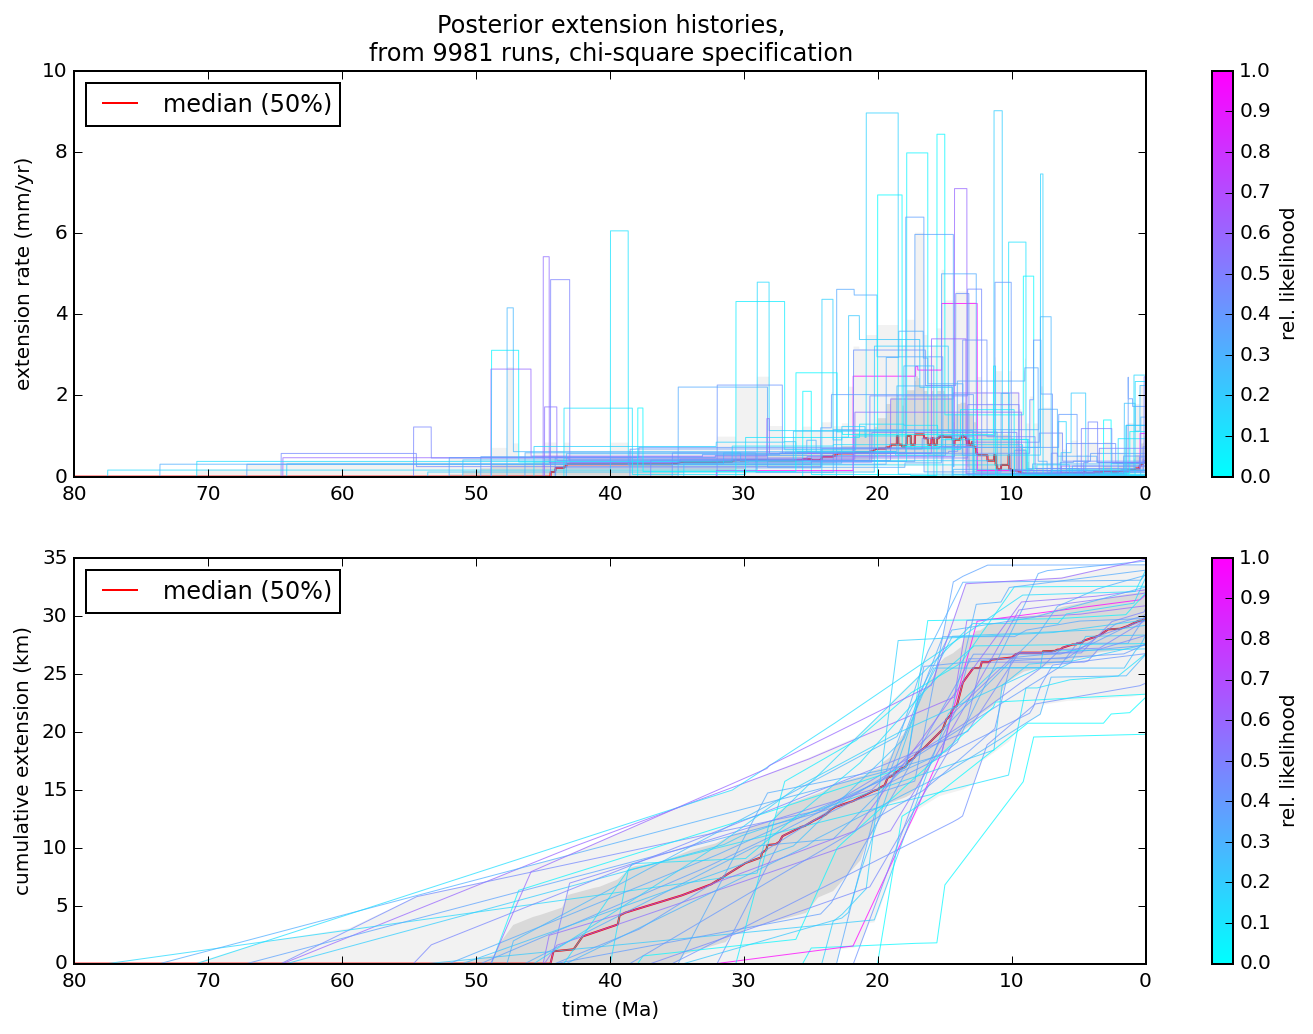

In [38]:
plot_percs=True

plt.figure(figsize=(12,8))

ones = np.ones(time_vec.shape)

plt.subplot(211)
plt.title('Posterior extension histories,\n'+
          'from {} runs, chi-square specification'.format(len(compar_list)))

if plot_percs:
    
    plt.fill_between(time_vec, np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index].values, 95, axis=1),
                               np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index].values, 5, axis=1),
                     facecolor='0.95', lw=0, label='5%/ 95%')
    
    plt.fill_between(time_vec, np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index], 25, axis=1),
                               np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index], 75, axis=1),
                     facecolor='0.85', lw=0, label='25% / 75%' )
    
    plt.plot(time_vec, np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index], 50, axis=1), 
         'r', label='median (50%)' )
    #plt.plot(time_vec, np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index], 75, axis=1), 'k', lw=0.5 )
    #plt.plot(time_vec, np.percentile(chi_sq_rate_history.loc[:,chi_sq_keeps.index], 95, axis=1), 'grey', lw=1 )


for run_id in chi_sq_keeps.index.values:
    plt.plot(time_vec, chi_sq_rate_history.loc[:,run_id], #',',
             #c=get_color(run_params.loc[run_id].heat_prod, 5, 50, cm.cool),
             c=get_color(chi_sq_keeps.loc[run_id].chi_sq_rel_like, 0, 1, cm.cool),
             #c='b',
             lw=0.5, alpha=0.75)



plt.ylabel('extension rate (mm/yr)')
plt.xlim([0,80])
plt.gca().invert_xaxis()
plt.legend(loc='upper left')

#plt.colorbar(mappable=get_mappable(5, 50, cm.cool), label='heat prod (°/Ma)')
plt.colorbar(mappable=get_mappable(0,1, cm.cool), label='rel. likelihood')



plt.subplot(212)

    
if plot_percs:
    
    plt.fill_between(time_vec, np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                            5, axis=1),
                               np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                             95,   axis=1),
                     facecolor='0.95', lw=0, label='5%-95%')
    
    plt.fill_between(time_vec, np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                                       25, axis=1),
                               np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                                       75, axis=1),
                     facecolor='0.85', lw=0, label='25%-75%')
    
    plt.plot(time_vec, np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
                                 50, axis=1), 'r', label='median (50%)')
    #plt.plot(time_vec, np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
    #                             75, axis=1), 'k', lw=0.5 )
    #plt.plot(time_vec, np.percentile(np.cumsum(chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
    #                             95, axis=1), 'grey', lw=1 )

    

for run_id in chi_sq_keeps.index.values:
    plt.plot(time_vec, 
             np.cumsum(chi_sq_rate_history.loc[:,run_id]) * 0.01,
             #c=get_color(run_params.loc[run_id].heat_prod, 5, 50, cm.cool),
             c=get_color(chi_sq_keeps.loc[run_id].chi_sq_rel_like, 0, 1, cm.cool),
             #c='b',
             lw=0.5, alpha=0.75)
    
    
plt.xlim([0,80])
plt.gca().invert_xaxis()
plt.xlabel('time (Ma)')
plt.ylabel('cumulative extension (km)')
#plt.colorbar()
plt.legend(loc='upper left')

plt.colorbar(mappable=get_mappable(0,1, cm.cool), label='rel. likelihood')
#plt.colorbar(mappable=get_mappable(5, 50, cm.cool), label='heat prod (°/Ma)')

#plt.savefig('/Users/itchy/Desktop/ssr_history.pdf')

plt.show()


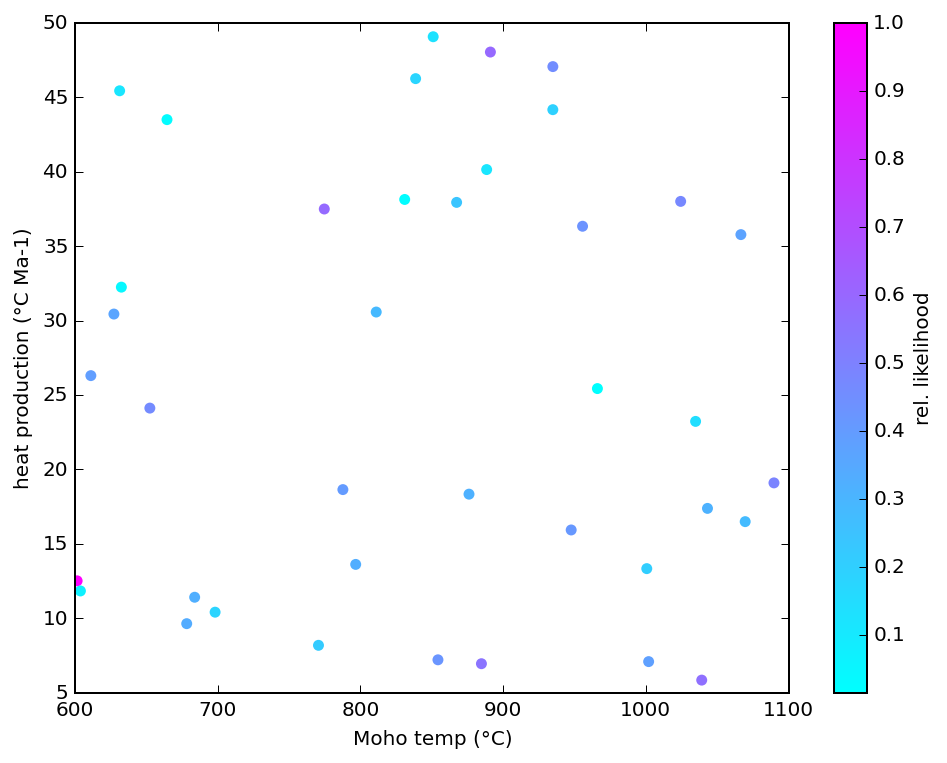

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(run_params.loc[chi_sq_keeps.index].moho_T, 
            run_params.loc[chi_sq_keeps.index].heat_prod,
            c=chi_sq_keeps.chi_sq_rel_like, cmap=cm.cool,
            s=30, lw=0, alpha=1)
plt.xlim([600,1100])
plt.ylim([5,50])
plt.colorbar(label='rel. likelihood')

plt.xlabel('Moho temp (°C)')
plt.ylabel('heat production (°C Ma-1)')
#plt.savefig('/Users/itchy/Desktop/heat_params.pdf')
plt.show()

In [40]:
def plot_model_data(run_id, symbol, chrons, mask=True, alpha=1):
    mod_df = master_df.loc[run_id]
    
    if mask==True:
        mask = age_df.notnull()
        mod_df = mod_df[mask]
    
    if 'aFt' in chrons:
        plt.plot(mod_df.aFt_calc, thermo_df.elev, 'b{}'.format(symbol), alpha=alpha)
    
    if 'zFt' in chrons:
        plt.plot(mod_df.zFt_calc, thermo_df.elev, 'r{}'.format(symbol), alpha=alpha )
    
    if 'aHe' in chrons:
        plt.plot(mod_df.aHe_calc, thermo_df.elev, 'g{}'.format(symbol), alpha=alpha )
    
    if 'zHe' in chrons:
        plt.plot(mod_df.zHe_calc, thermo_df.elev, 'm{}'.format(symbol), alpha=alpha )
        
    

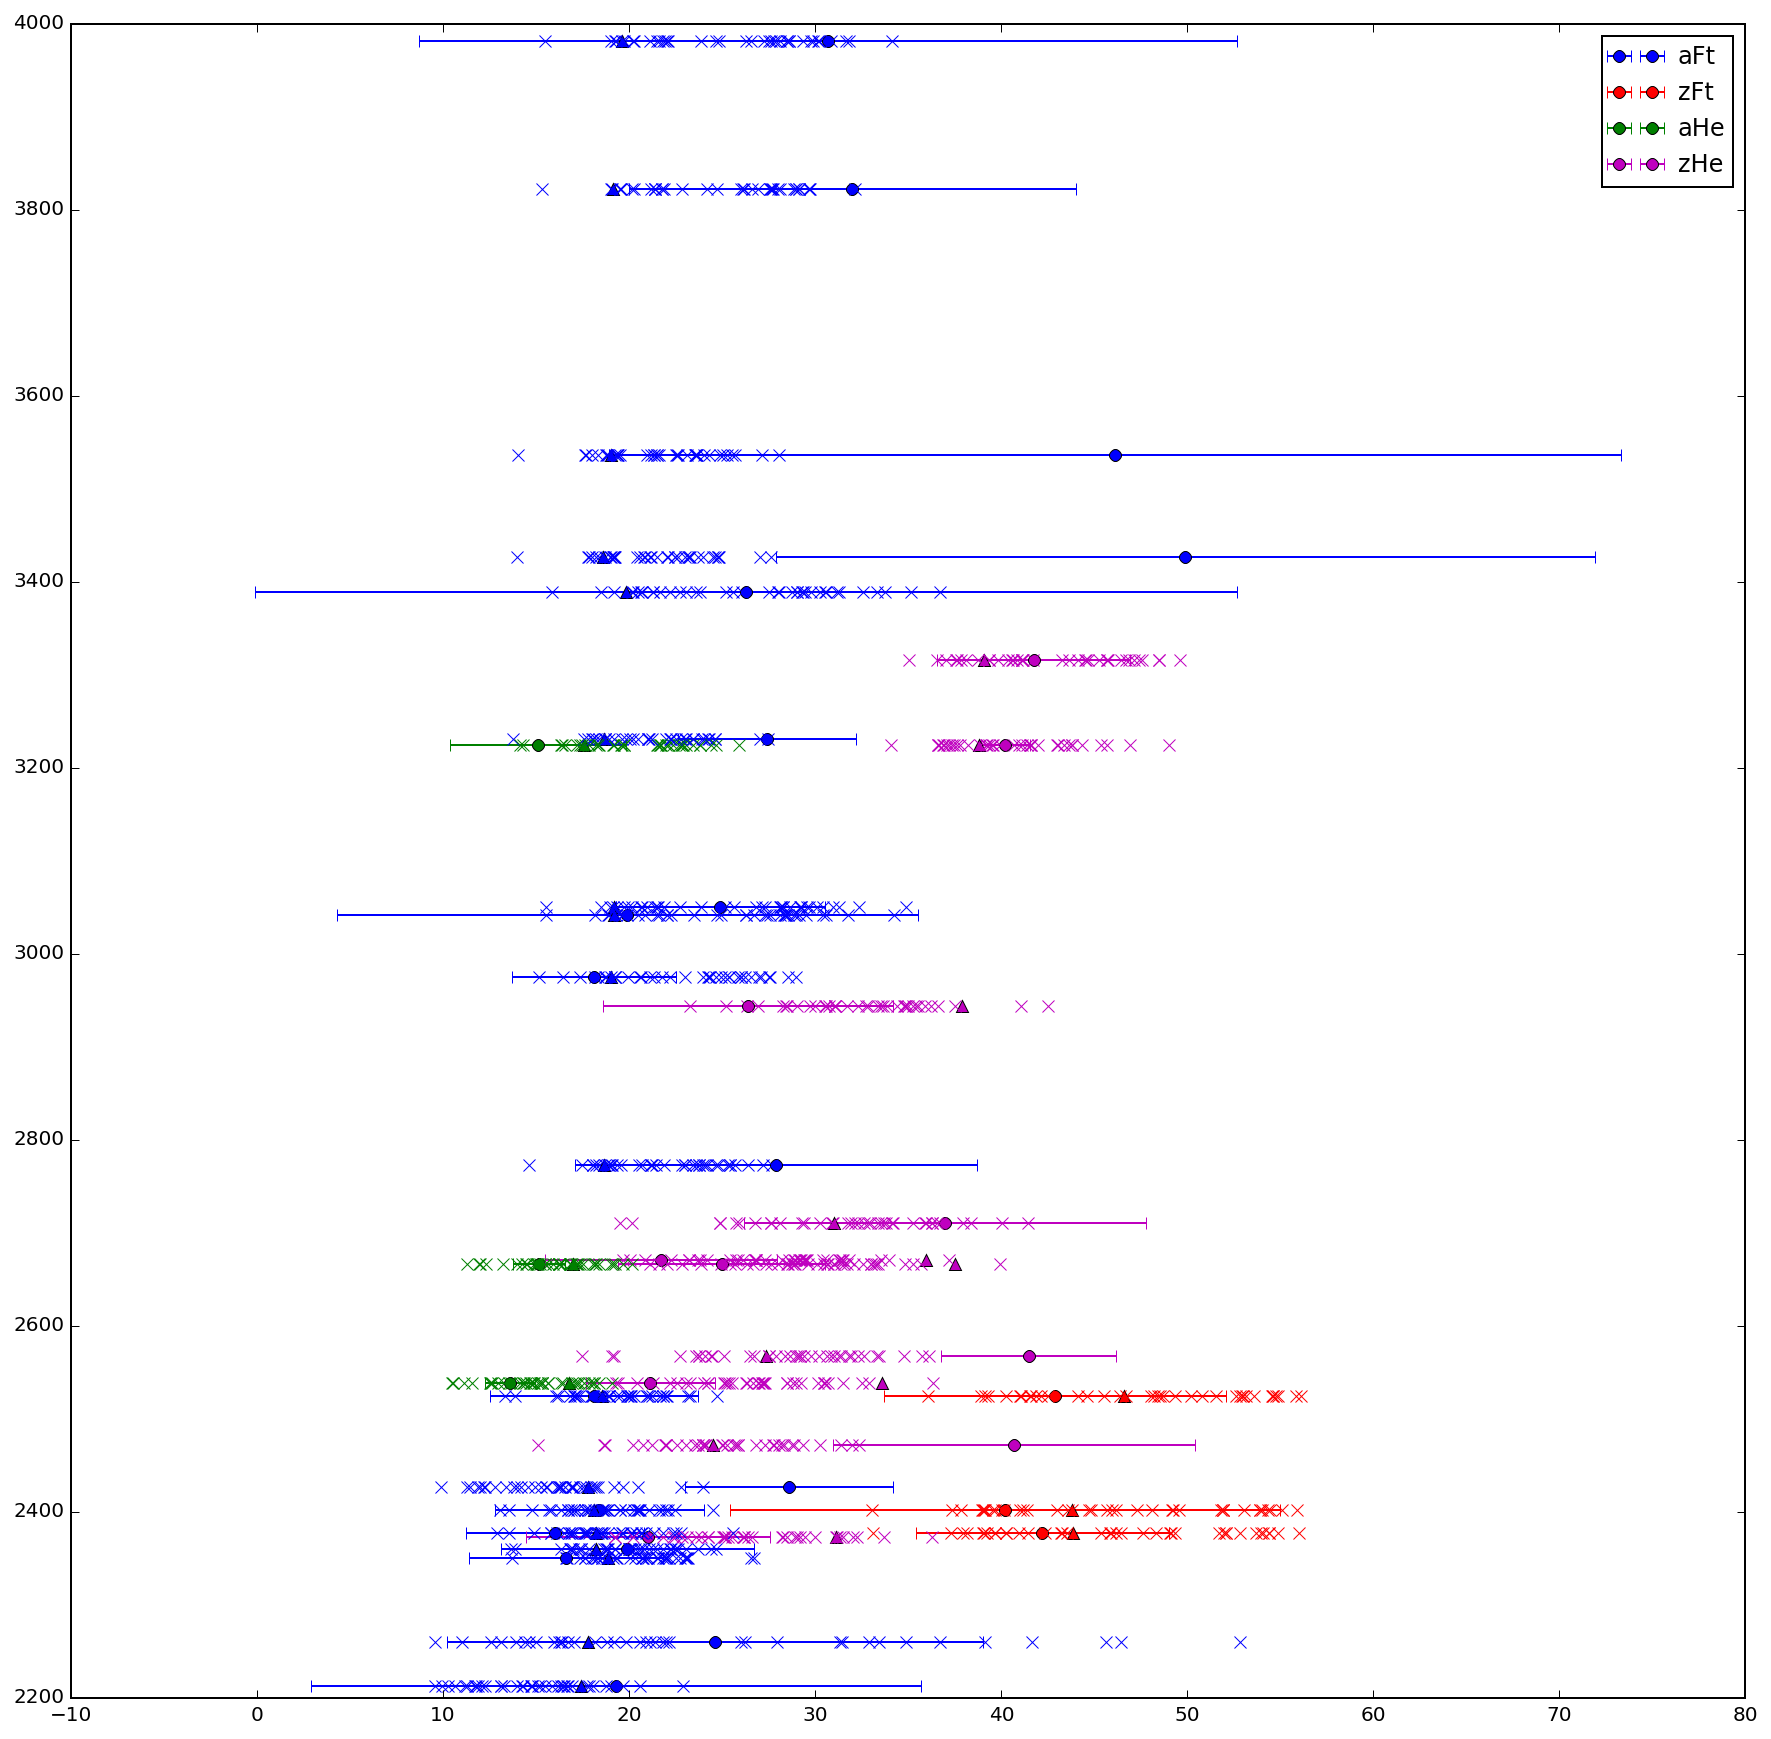

In [41]:
chrons = ['aFt', 'zHe', 'zFt', 'aHe']

plt.figure(figsize=(15,15))


if 'aFt' in chrons:
    plt.errorbar(age_df.aFt_calc, thermo_df.elev, 
             xerr=thermo_df.aFt_err*2, fmt='bo', label='aFt')


if 'zFt' in chrons:
    plt.errorbar(age_df.zFt_calc, thermo_df.elev, 
             xerr=thermo_df.zFt_err*2, fmt='ro', label='zFt')

if 'aHe' in chrons:
    plt.errorbar(age_df.aHe_calc, thermo_df.elev, 
             xerr=thermo_df.aHe_err*2, fmt='go', label='aHe')

if 'zHe' in chrons:
    plt.errorbar(age_df.zHe_calc, thermo_df.elev, 
             xerr=thermo_df.zHe_err*2, fmt='mo', label='zHe')



plot_model_data('0a88b1', '^', chrons)

#plot_model_data('132d01', '+', chrons)

for rr in chi_sq_keeps.index:
    plot_model_data(rr, 'x', chrons, alpha=1)

plt.legend()

#plt.savefig('/Users/itchy/Desktop/ssrd_age_elev.pdf')
#plt.plot()
plt.show()

In [43]:
def plot_detach_dist(run_id, symbol, chrons, mask=True, alpha=1):
    mod_df = master_df.loc[run_id]
    
    if mask==True:
        mask = age_df.notnull()
        mod_df = mod_df[mask]
    
    if 'aFt' in chrons:
        plt.plot(thermo_df.lon, mod_df.aFt_calc, 'b{}'.format(symbol), alpha=alpha)
    
    if 'zFt' in chrons:
        plt.plot(thermo_df.lon, mod_df.zFt_calc, 'r{}'.format(symbol), alpha=alpha )
    
    if 'aHe' in chrons:
        plt.plot(thermo_df.lon, mod_df.aHe_calc, 'g{}'.format(symbol), alpha=alpha )
    
    if 'zHe' in chrons:
        plt.plot(thermo_df.lon, mod_df.zHe_calc, 'm{}'.format(symbol), alpha=alpha )

In [44]:
thermo_df.lon.min()

-114.367222

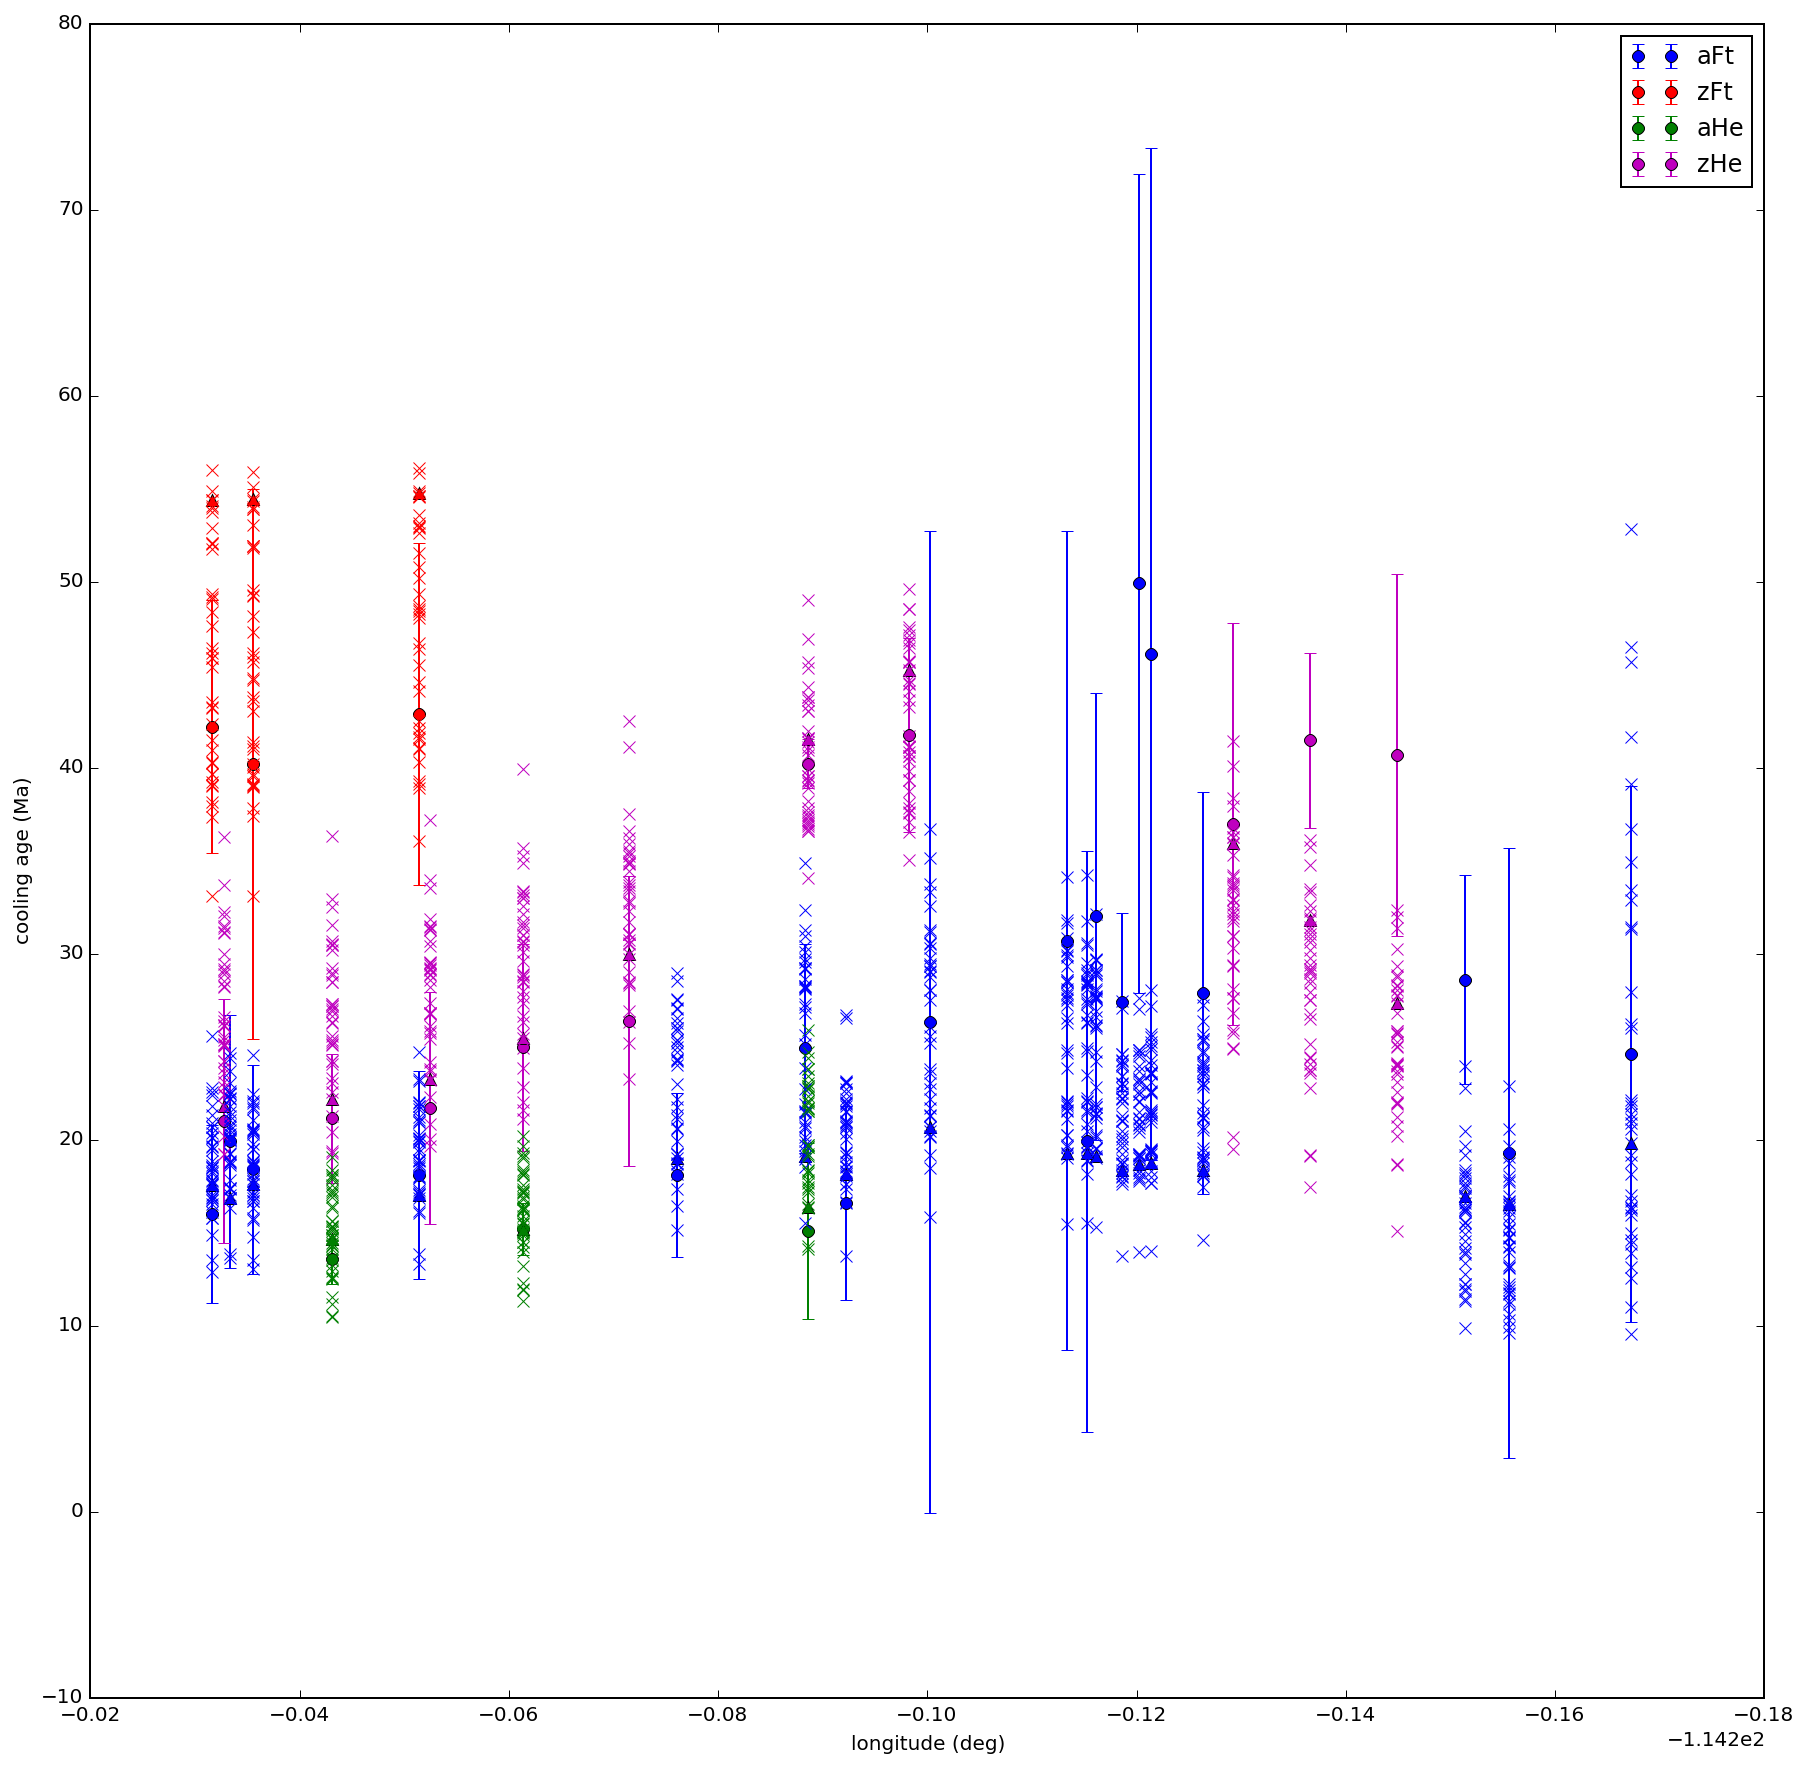

In [46]:
chrons = ['aFt', 'zHe', 'zFt', 'aHe']

plt.figure(figsize=(15,15))


if 'aFt' in chrons:
    plt.errorbar(thermo_df.lon, age_df.aFt_calc,  
             yerr=thermo_df.aFt_err*2, fmt='bo', label='aFt')


if 'zFt' in chrons:
    plt.errorbar(thermo_df.lon, age_df.zFt_calc,  
             yerr=thermo_df.zFt_err*2, fmt='ro', label='zFt')

if 'aHe' in chrons:
    plt.errorbar(thermo_df.lon, age_df.aHe_calc,  
             yerr=thermo_df.aHe_err*2, fmt='go', label='aHe')

if 'zHe' in chrons:
    plt.errorbar(thermo_df.lon, age_df.zHe_calc,  
             yerr=thermo_df.zHe_err*2, fmt='mo', label='zHe')



plot_detach_dist('2722de', '^', chrons)

#plot_model_data('132d01', '+', chrons)

for rr in chi_sq_keeps.index:
    plot_detach_dist(rr, 'x', chrons, alpha=1)

plt.legend()

plt.xlim([-114.38, -114.22])

plt.gca().invert_xaxis()

plt.xlabel('longitude (deg)')
plt.ylabel('cooling age (Ma)')

plt.savefig('/Users/itchy/Desktop/ssrd_lon_age.pdf')
#plt.plot()
plt.show()

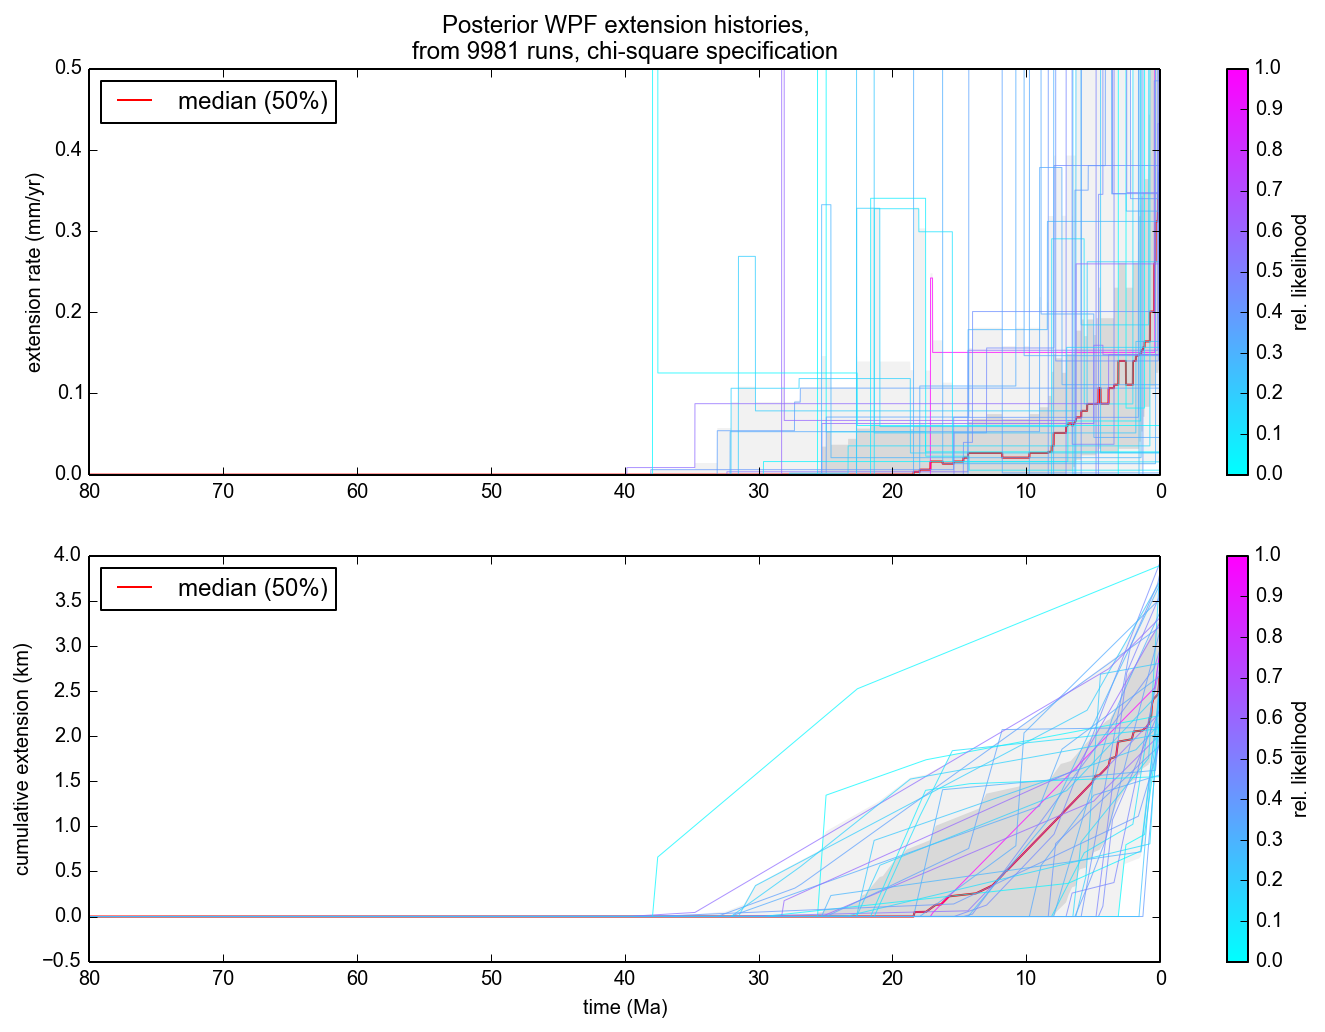

In [61]:
plot_percs=True

plt.figure(figsize=(12,8))

ones = np.ones(time_vec.shape)

plt.subplot(211)
plt.title('Posterior WPF extension histories,\n'+
          'from {} runs, chi-square specification'.format(len(compar_list)))

if plot_percs:
    
    plt.fill_between(time_vec, np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index].values, 95, axis=1),
                               np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index].values, 5, axis=1),
                     facecolor='0.95', lw=0, label='5%/ 95%')
    
    plt.fill_between(time_vec, np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], 25, axis=1),
                               np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], 75, axis=1),
                     facecolor='0.85', lw=0, label='25% / 75%' )
    
    plt.plot(time_vec, np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], 50, axis=1), 
         'r', label='median (50%)' )
    #plt.plot(time_vec, np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], 75, axis=1), 'k', lw=0.5 )
    #plt.plot(time_vec, np.percentile(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], 95, axis=1), 'grey', lw=1 )


for run_id in chi_sq_keeps.index.values:
    plt.plot(time_vec, wpf_chi_sq_rate_history.loc[:,run_id], #',',
             #c=get_color(run_params.loc[run_id].heat_prod, 5, 50, cm.cool),
             c=get_color(chi_sq_keeps.loc[run_id].chi_sq_rel_like, 0, 1, cm.cool),
             #c='b',
             lw=0.5, alpha=0.75)



plt.ylabel('extension rate (mm/yr)')
plt.xlim([0,80])
plt.ylim([0, 0.5])
plt.gca().invert_xaxis()
plt.legend(loc='upper left')

#plt.colorbar(mappable=get_mappable(5, 50, cm.cool), label='heat prod (°/Ma)')
plt.colorbar(mappable=get_mappable(0,1, cm.cool), label='rel. likelihood')



plt.subplot(212)

    
if plot_percs:
    
    plt.fill_between(time_vec, np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                            5, axis=1),
                               np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                             95,   axis=1),
                     facecolor='0.95', lw=0, label='5%-95%')
    
    plt.fill_between(time_vec, np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                                       25, axis=1),
                               np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0) * 0.01,
                                                       75, axis=1),
                     facecolor='0.85', lw=0, label='25%-75%')
    
    plt.plot(time_vec, np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
                                 50, axis=1), 'r', label='median (50%)')
    #plt.plot(time_vec, np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
    #                             75, axis=1), 'k', lw=0.5 )
    #plt.plot(time_vec, np.percentile(np.cumsum(wpf_chi_sq_rate_history.loc[:,chi_sq_keeps.index], axis=0)  * 0.01,
    #                             95, axis=1), 'grey', lw=1 )

    

for run_id in chi_sq_keeps.index.values:
    plt.plot(time_vec, 
             np.cumsum(wpf_chi_sq_rate_history.loc[:,run_id]) * 0.01,
             #c=get_color(run_params.loc[run_id].heat_prod, 5, 50, cm.cool),
             c=get_color(chi_sq_keeps.loc[run_id].chi_sq_rel_like, 0, 1, cm.cool),
             #c='b',
             lw=0.5, alpha=0.75)
    
    
plt.xlim([0,80])
plt.gca().invert_xaxis()
plt.xlabel('time (Ma)')
plt.ylabel('cumulative extension (km)')
#plt.colorbar()
plt.legend(loc='upper left')

plt.colorbar(mappable=get_mappable(0,1, cm.cool), label='rel. likelihood')
#plt.colorbar(mappable=get_mappable(5, 50, cm.cool), label='heat prod (°/Ma)')

#plt.savefig('/Users/itchy/Desktop/wpf_history.pdf')

plt.show()



In [50]:
wpf_chi_sq_rate_history.loc[0,:].describe()

count    39.000000
mean      0.398318
std       0.463440
min       0.002093
25%       0.098471
50%       0.166879
75%       0.470691
max       1.897533
Name: 0.0, dtype: float64

In [52]:
wpf_chi_sq_rate_history.loc[40:, :].median().median()

0.0

In [65]:
post_run_params = run_params.loc[chi_sq_keeps.index]

post_run_params.to_csv('post_run_params.csv')

post_run_params.tA3.describe()

count    39.000000
mean     17.203403
std       5.823168
min       7.784239
25%      13.651197
50%      16.829403
75%      19.725228
max      33.584557
Name: tA3, dtype: float64

In [54]:
post_run_params.wpf_extension.describe()

count    39.000000
mean      2.789918
std       0.614103
min       1.732230
25%       2.216388
50%       2.942151
75%       3.216579
max       3.975439
Name: wpf_extension, dtype: float64

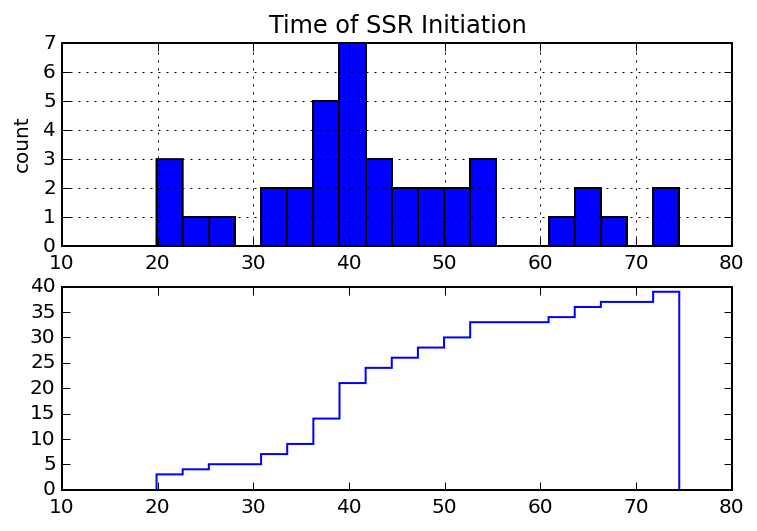

In [55]:
plt.figure()
plt.subplot(211)
post_run_params.tA1.hist(bins=20)
plt.ylabel('count')
plt.title('Time of SSR Initiation')


#plt.subplot(212)
#post_run_params.tA1.plot(kind='kde')
#plt.xlim([10,80])
#plt.xlabel('time (Ma)')

#plt.savefig('/Users/itchy/Desktop/ssr_init.pdf')

plt.subplot(212)
plt.hist(post_run_params.tA1, bins=20, cumulative=True, histtype='step')

plt.show()

In [56]:
post_run_params.corr()

,tA1,tA2,tA3,tA4,tA5,rA1,rA2,rA3,rA4,ssrd_extension,...,tB2,tB3,tB4,rB1,rB2,rB3,wpf_extension,net_extension,moho_T,heat_prod
tA1,1.000000,0.503773,0.141175,0.004686,NaN,-0.295754,-0.130152,-0.083381,NaN,0.370224,...,-0.006314,0.093549,NaN,0.032090,-0.121790,-0.209057,-0.439736,0.320314,-0.155728,0.237276
tA2,0.503773,1.000000,0.173161,0.051701,NaN,0.232825,-0.416413,0.030904,NaN,-0.007981,...,-0.176721,-0.212227,NaN,0.070024,-0.141467,0.178510,-0.155961,-0.032195,0.014424,0.347781
tA3,0.141175,0.173161,1.000000,0.196536,NaN,-0.101662,0.477701,-0.366406,NaN,-0.147824,...,0.103133,0.214441,NaN,0.163900,0.108511,-0.142647,0.050487,-0.147018,-0.124967,0.044798
tA4,0.004686,0.051701,0.196536,1.000000,NaN,-0.001987,-0.022595,0.407117,NaN,-0.226469,...,0.279032,-0.109509,NaN,0.261343,0.034205,0.072517,0.247945,-0.199156,0.029603,0.110804
tA5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rA1,-0.295754,0.232825,-0.101662,-0.001987,NaN,1.000000,0.008338,-0.038322,NaN,-0.121616,...,-0.315704,-0.246071,NaN,-0.167926,0.062753,0.229995,0.119778,-0.108992,0.063937,0.108775
rA2,-0.130152,-0.416413,0.477701,-0.022595,NaN,0.008338,1.000000,-0.325822,NaN,0.043527,...,0.036594,0.278186,NaN,-0.079376,0.067545,-0.200907,0.015323,0.047904,-0.183430,-0.156049
rA3,-0.083381,0.030904,-0.366406,0.407117,NaN,-0.038322,-0.325822,1.000000,NaN,0.016338,...,0.181252,-0.151073,NaN,0.162033,-0.007686,0.248034,0.146218,0.039453,0.094078,-0.121060
rA4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ssrd_extension,0.370224,-0.007981,-0.147824,-0.226469,NaN,-0.121616,0.043527,0.016338,NaN,1.000000,...,-0.156526,-0.096222,NaN,-0.213993,-0.005881,0.181193,-0.372048,0.989883,-0.410614,-0.514834


In [57]:
chi_sq_cum_history = chi_sq_rate_history.cumsum() * 0.01

med ext at 34 is 5.216337225104111
med ext at 23 is 11.351591729094128


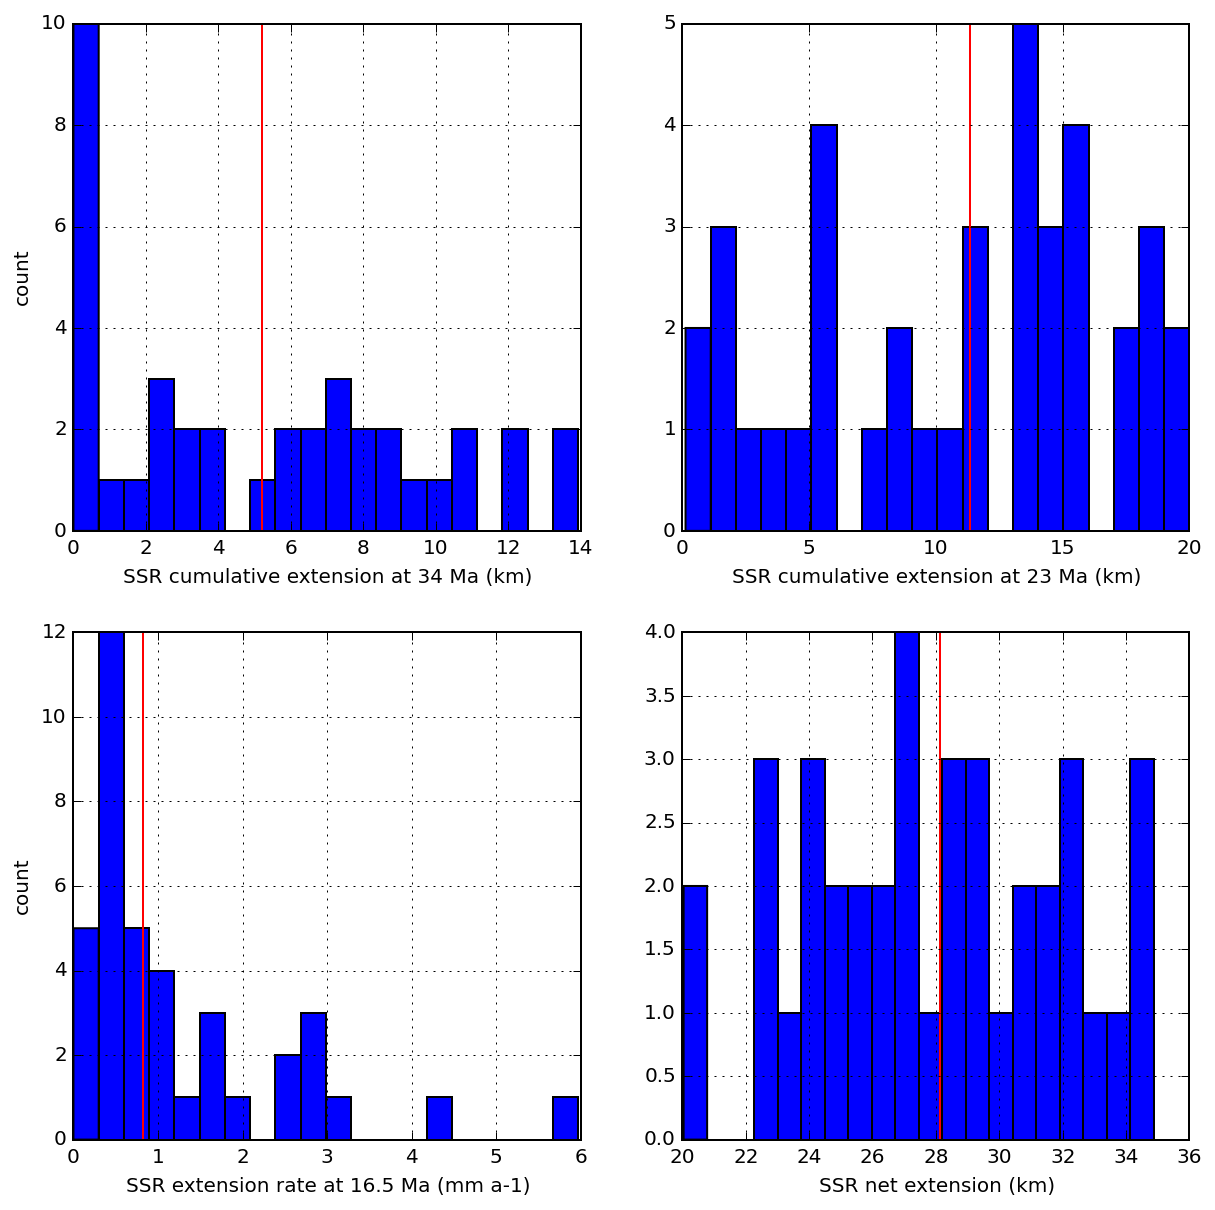

In [58]:
plt.figure(figsize=(10,10))

plt.subplot(221)
time = 34
chi_sq_cum_history.loc[time, :].hist(bins=20)
plt.xlabel('SSR cumulative extension at {} Ma (km)'.format(time))
plt.axvline(chi_sq_cum_history.loc[time, :].median(), c='r')
plt.ylabel('count')

print('med ext at {} is {}'.format(time, chi_sq_cum_history.loc[time, :].median() ))


plt.subplot(222)
time = 23
chi_sq_cum_history.loc[time, :].hist(bins=20)
plt.xlabel('SSR cumulative extension at {} Ma (km)'.format(time))
plt.axvline(chi_sq_cum_history.loc[time, :].median(), c='r')

print('med ext at {} is {}'.format(time, chi_sq_cum_history.loc[time, :].median()))


plt.subplot(223)

time = 16.5

chi_sq_rate_history.loc[time, :].hist(bins=20)
plt.axvline(chi_sq_rate_history.loc[time, :].median(),c='r')
plt.xlabel('SSR extension rate at {} Ma (mm a-1)'.format(time))
plt.ylabel('count')

plt.subplot(224)

post_run_params.net_extension.hist(bins=20)

plt.axvline( post_run_params.net_extension.median(), c='r')
plt.xlabel('SSR net extension (km)')

#plt.savefig('/Users/itchy/Desktop/slip_histograms.pdf')


In [59]:
post_run_params.net_extension.describe()

count    39.000000
mean     27.967353
std       4.017350
min      20.045437
25%      24.812486
50%      28.129929
75%      31.275460
max      34.876351
Name: net_extension, dtype: float64

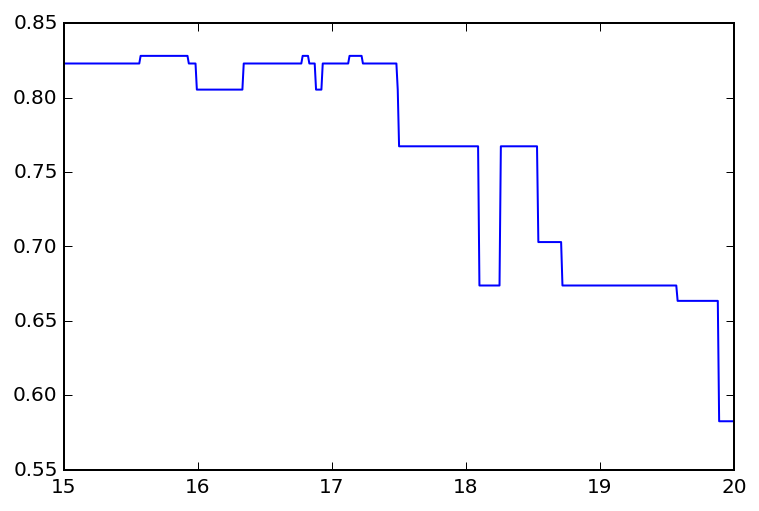

In [60]:
plt.plot(chi_sq_rate_history.loc[20:15, :].index,
         chi_sq_rate_history.loc[20:15, :].median(axis=1) )

In [61]:
chi_sq_rate_history

,549e03,882978,aa38c5,537383,0b4238,bc74b3,1db8d0,7736f2,edb057,d0cda6,...,4b8a49,538629,6e59d0,83005c,ac7030,e4230e,dfebd3,67a2b3,6c1759,df904c
80.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.97,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.93,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79.91,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
